In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [139]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

# Modèle 03 



## Get the data

### Météo

In [110]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('10/06/2017', format='%d/%m/%Y'), pd.to_datetime('now')

In [111]:
# download the data:
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 1, done


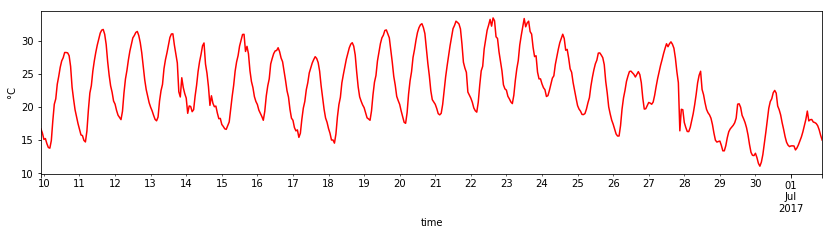

In [112]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

### Irradiation solaire

In [113]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


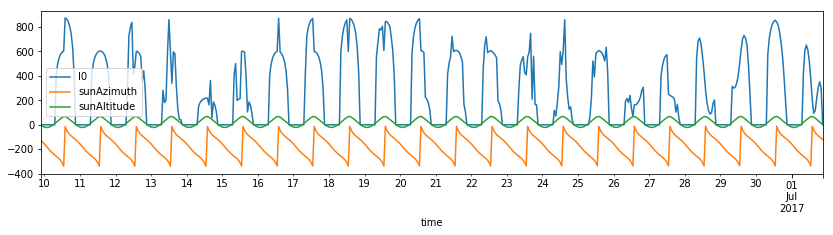

In [114]:
sundata.plot(figsize=(14, 3))

In [115]:
sigma = 37  # deg, angle du toit
phi_C = 50  # deg, azimuth du toit

In [116]:
sunFlux_dict = {'flux_bastille':sun.projectDF( 37, 50, sundata ), 
                'flux_cuisine':sun.projectDF( 90, 50, sundata ),
           'flux_vercors': sun.projectDF( 37, 180+50, sundata),
            'flux_chambre': sun.projectDF( 90, 180+50, sundata )}

sunFlux = pd.DataFrame( sunFlux_dict )

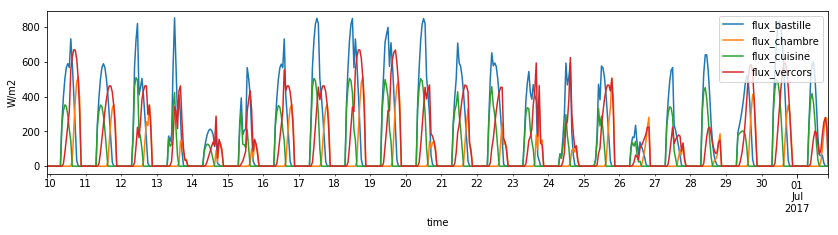

In [117]:
sunFlux.plot(figsize=(14, 3)); plt.ylabel('W/m2');

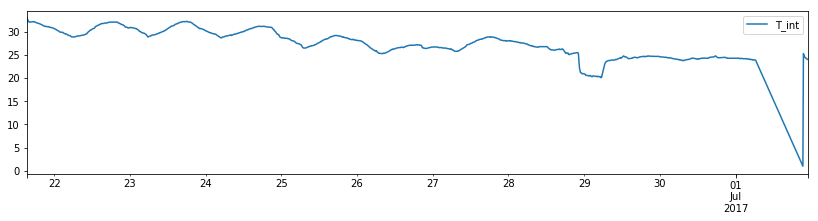

In [173]:
# Temp mesurée

dataframefreq = '10min'
feeds =  { 'T_int':3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq ) # startdate=pd.to_datetime('22/06/2017')
Tmesure.plot( figsize=(14, 3) );


## Grandeurs physiques

propriétés double vitrage: https://www.energieplus-lesite.be/index.php?id=10396#c2234

### fenètres

In [118]:
windows_size = { 'bastille':(1.2, 0.8),
            'cuisine1':(0.3, 0.72),
           'cuisine2':(0.3, 0.72),
            'chambre1':(0.3, 0.72),
            'chambre2':(0.3, 0.72),
            'vercors1':(0.6, 0.8),
            'vercors2':(0.6, 0.8),
            'sdb':(0.25, 0.25)
          }

In [119]:
def get_Ufenetre( largeur, hauteur ):
    k_vitre = 2.8 # W/m2/K
    surface = hauteur * largeur
    U_vitre = surface*k_vitre # W/K

    # https://www.energieplus-lesite.be/index.php?id=17039
    psi = 0.06 # W/m/K
    perimetre = 2*(hauteur + largeur)
    U_chassis = psi*perimetre # W/K

    Ufenetres = U_vitre + U_chassis
    
    return Ufenetres

In [120]:
Ufenetre = sum(  [ get_Ufenetre( *dim ) for dim in windows_size.values() ] )

print('Ufenetres: %f W/K'%Ufenetre)

Ufenetres: 9.095800 W/K


#### Rayonement

In [229]:
Facteur_g = 0.76 * 0.5 # Facteur solaire (prend en compte l'absorption et la ré-émission)

In [230]:
def surf( k ):
    return windows_size[k][0]*windows_size[k][1]

In [231]:
weatherdata['flux_tot'] =( surf('bastille')*sunFlux_dict['flux_bastille'] \
            + 2*surf('cuisine1')*sunFlux_dict['flux_cuisine'] \
            + 2*surf('chambre1')*sunFlux_dict['flux_chambre']\
            + 2*surf('vercors1')*sunFlux_dict['flux_vercors'] )*Facteur_g

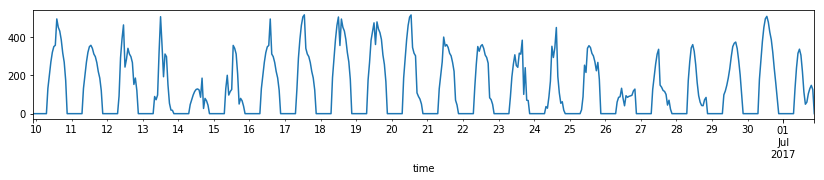

In [232]:
weatherdata['flux_tot'].plot(figsize=(14, 2))

### Masse thermique mur & sol

In [233]:
Ri = 0.14  # coef échange intérieure mur, W/m2/K
S_wall = 58 + 2*22.7 # m2

U_wall = Ri*S_wall

print( U_wall )

14.476000000000003


In [249]:
ep_wall = 0.5  #m 

N = 17  # nombre de mailles pour le calcul
X = np.linspace(0, ep_wall, N)
dx = ep_wall/(N-1)

In [250]:
rhoCp = 1400e3 # densité*Capacité thermique, J/m3/K
k = 1.75  #  conductivité, W/m/K

alpha = k/rhoCp # diffusivité, s.m-2

print('t_carac %.2f h'%(ep_wall**2/alpha/60/60))

t_carac 55.56 h


### Air :

In [251]:
Volume = 22.7*7.94 # m2
rhoCp_air = 1256 # J/m3/K 

Mth_air = rhoCp_air*Volume

In [252]:
taux = 0.5 # Volume / heure
U_aeration = taux * Volume/60/60 * rhoCp_air

In [253]:
U_aeration

31.441517777777776

## Solveur

In [254]:
""" Interpolation des données météo
"""
data_dict = weatherdata.to_dict(orient='list')
time_sec = weatherdata.index.astype(np.int64) // 10e9

def getdatarow( t ):
    datarow = {}
    for key, data in data_dict.items():
        datarow[key] = np.interp( t, time_sec, data )
    return datarow

def interpoldata( t, key):
    data = np.interp( t, time_sec, data_dict[key] )
    return data

In [255]:
getdatarow(  149859002 )

{'cloudCover': 0.7407222222222222,
 'flux_tot': 69.85895402161806,
 'precipIntensity': 0.0,
 'temperature': 25.330833333333334,
 'windBearing': 230.02777777777777,
 'windSpeed': 3.969888888888889}

In [256]:
interpoldata( 149859002, 'temperature' )

25.330833333333334

In [257]:
from scipy.optimize import brentq

In [258]:
def Laplacien( U, dx=1 ):
    """ Calcul le laplacien du vecteur U
        avec des conditions aux limites adiabatiques 
    """
    d2Udx2 = np.zeros_like( U )
    
    U_i = U[1:-1]
    U_im1 = U[0:-2]
    U_ip1 = U[2:]

    d2Udx2[1:-1] = ( U_ip1 + U_im1 -2*U_i )/dx**2
    
    d2Udx2[0] = -(U[0]-U[1])/dx
    d2Udx2[-1] = (U[-2] - U[-1])/dx
    
    return d2Udx2

In [259]:
def get_dTdt( T, t ):
    
    
    Tint = T[0]
    Twall = T[1:]

    #weatherdata = interpoldata(  t, 'temperature' )
    T_ext = interpoldata(  t, 'temperature' )
    flux_tot =  interpoldata(  t, 'flux_tot' )
        
    Uext = Ufenetres + U_aeration
    dTint_dt = 1/Mth_air*( Uext*( T_ext - Tint ) + U_wall*( Twall[0] - Tint ) + flux_tot )
    
    dTdt_wall = alpha*Laplacien( Twall, dx=dx )

    dTdt_wall[0] += -U_wall*( Twall[0] - Tint )
    
    dTdt = np.zeros_like( T )
    dTdt[0] = dTint_dt
    dTdt[1:] = dTdt_wall
    
    return dTdt

In [260]:
from scipy.integrate import odeint

In [261]:
Tzero = np.ones(N+1) * weatherdata['temperature'].mean()


res = odeint(get_dTdt, Tzero, time_sec)

In [262]:
cols = {'T_air':res[:, 0], 'T_wall':res[:, 1]}
results = pd.DataFrame(  cols, index=weatherdata.index )

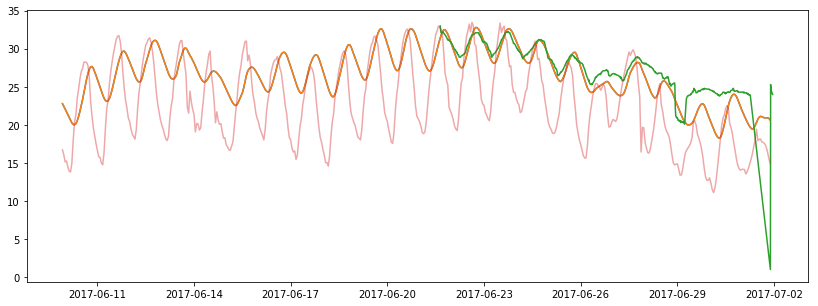

In [264]:
plt.figure( figsize=(14, 5) )
plt.plot(results)
plt.plot(Tmesure)
plt.plot(weatherdata['temperature'], alpha=0.4)

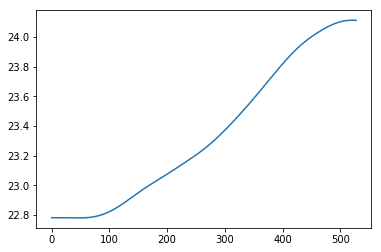

In [263]:
plt.plot( res[:, -1] )

# Avec ODE

In [260]:
from scipy.integrate import ode

In [257]:
get_dTdt_ode = lambda t, T:  get_dTdt( T, t )

solveur = ode( get_dTdt_ode ).set_integrator('dopri5')
solveur.set_initial_value(Tzero, t_span[0]) #.set_f_params(2.0).set_jac_params(2.0)

In [258]:
solveur

In [259]:
solveur.integrate( t_span[1] )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


array([ 22.36683829,  22.36680953,  22.36915171,  22.3691666 ,
        22.36916667,  22.36916667,  22.36916667,  22.36916667])

In [252]:
for t1 in t_span[1:]:
    if solveur.successful():
        print(solveur.t, solveur.integrate( t1 ))

TypeError: 'float' object is not subscriptable

# Old

In [120]:
def model02_apply( datarow, colflux=None, disp=False  ):
    flux_soleil = datarow[ colflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )
    
    emissivite_tuile = 0.92

    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    convection = lambda T: -h * (T - T_air)
    rayonement_toit = lambda T: -sigmaSB*emissivite_tuile*( T + 273 )**4
    #rayonement_ciel =  +sigmaSB*( T_air + 273 )**4  # insert cloud cover here
    rayonement_ciel = Goforth_skyrad( datarow )
    
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    # Resolution numérique, recherche du zéro:
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    if disp:
        print( convection(T_eq), rayonement_toit(T_eq), rayonement_soleil, rayonement_ciel )
    
    return T_eq

In [121]:
def Goforth_skyrad( datarow ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    C = datarow['cloudCover']
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = datarow['temperature'] + 273
    RH = datarow['humidity']*100

    Pthermal = ( 1 + K*C**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal